# Model description
**Outcome variable**
- price (eth)  

**Explanatory variables**
- collection features (daily): volume, total trades, price max, price min, price 5%  
- last sale: price_last_sale, time_last_sale  
- traits/rarity: (1 categorical variable for each trait), rarity rank  

**Models used (sklearn)**
- Linear Models: OLS, Lasso, Ridge
- Ensemble: random forest, gradient boosting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file = "bayc_cleaned.csv"
df = pd.read_csv(f"data/{file}", index_col=0)

In [3]:
df.head()

,project,version,block_date,block_month,block_time,token_id,collection,amount_usd,token_standard,trade_type,...,Mouth_value,Mouth_count,Eyes_value,Eyes_count,Fur_value,Fur_count,Clothes_value,Clothes_count,Earring_value,Earring_count
0,x2y2,v1,2023-01-22,2023-01-01,2023-01-22 00:30:23+00:00,5,Bored Ape Yacht Club,317355.814,erc721,secondary,...,Dumbfounded,505,X Eyes,243,Brown,1370,Bayc T Red,140,Empty,6383
1,opensea,v1,2021-06-21,2021-06-01,2021-06-21 15:56:28+00:00,6,Bored Ape Yacht Club,19761.700,erc721,Single Item Trade: Fixed price,...,Bored,2272,Crazy,407,Cream,636,Tweed Suit,141,Empty,6383
2,opensea,v1,2021-12-22,2021-12-01,2021-12-22 19:16:09+00:00,6,Bored Ape Yacht Club,251182.890,erc721,Single Item Trade: Fixed price,...,Bored,2272,Crazy,407,Cream,636,Tweed Suit,141,Empty,6383
3,opensea,v3,2022-07-03,2022-07-01,2022-07-03 16:40:36+00:00,6,Bored Ape Yacht Club,93910.130,erc721,single item trade,...,Bored,2272,Crazy,407,Cream,636,Tweed Suit,141,Empty,6383
4,opensea,v3,2022-10-21,2022-10-01,2022-10-21 00:56:23+00:00,8,Bored Ape Yacht Club,141705.300,erc721,single item trade,...,Bored,2272,Robot,350,Zombie,302,Empty,1690,Gold Stud,439


In [4]:
# define column sets
feature_columns = {
    "market" : ['volume_eth', 'price_p5_eth_lag1', 'price_max_eth_lag1', 'price_min_eth_lag1'],
    "traits_rarity" : ['rarity_rank', 'Background_count', 'Mouth_count', 'Eyes_count', 'Fur_count', 'Hat_count', 'Clothes_count', 'Earring_count'],
    "last_trade" : ['last_trade_timediff', 'last_trade_price'],
}

outcome_columns = {
    'trade_price' : 'trade_price',
    'amount_usd' : 'amount_usd',
    'trade_price_log' : 'trade_price_log'
}

In [5]:
def df_to_xy(df, X_cols, y_col):
    
    # fetch variables of interest, drop missing values
    data = df.copy()
    n = len(data)
    data = data.dropna(subset=X_cols+[y_col])
    print(f"Number of observations: {len(data)}/{n}")
    
    X = data[X_cols]
    y = data[y_col]
    
    return X, y

# PCA Analysis

In [6]:
# PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def feature_PCA(df, X_cols, y_col, plot=False):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA())
    ])

    X,y = df_to_xy(df,X_cols,y_col)

    X_PCA = pipe.fit_transform(X)

    if plot:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2], c=y)
        ax.set_xlabel("PCA0")
        ax.set_ylabel("PCA1")
        ax.set_zlabel("PCA2")
        ax.set_title("PCA space")
        plt.show()

    return X_PCA

# Benchmark models
- Linear regression: OLS, Ridge, Lasso
- Tree-based model: Random Forest, gradient boosting

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


def benchmark_models(df, X_cols, y_col, models=None):
    
    if models is None:
        models = [
            'ols', 
            'lasso',
            'ridge',
            'rf',
            'gb'
            ]

    X,y = df_to_xy(df,X_cols,y_col)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # OLS regression
    if 'ols' in models:
        ols = LinearRegression()
        ols.fit(X_train,y_train)
        ols_pred = ols.predict(X_test)
        ols_mse = mean_squared_error(y_test, ols_pred)
        print(f"OLS MSE: {ols_mse}")

    # Lasso regression
    if "lasso" in models:
        lasso = Lasso(random_state=42)
        lasso.fit(X_train,y_train)
        lasso_pred = lasso.predict(X_test)
        lasso_mse = mean_squared_error(y_test, lasso_pred)
        print(f"Lasso MSE: {lasso_mse}")
    
    # Ridge regression
    if "ridge" in models:
        ridge = Ridge()
        ridge.fit(X_train,y_train)
        ridge_pred = ridge.predict(X_test)
        ridge_mse = mean_squared_error(y_test, ridge_pred)
        print(f"Ridge MSE: {ridge_mse}")
    
    # Random Forest regression
    if 'rf' in models:
        rf = RandomForestRegressor(random_state=42)
        rf.fit(X_train, y_train)
        rf_predictions = rf.predict(X_test)
        rf_mse = mean_squared_error(y_test, rf_predictions)
        print(f"Random Forest MSE: {rf_mse}")
    
    # Gradient Boosting regression
    if "gb" in models:
        gb = GradientBoostingRegressor(random_state=42)
        gb.fit(X_train, y_train)
        gb_predictions = gb.predict(X_test)
        gb_mse = mean_squared_error(y_test, gb_predictions)
        print(f"Gradient Boosting MSE: {gb_mse}")
        

# Example
predict trade price on base cols, base traits, and last trade

In [17]:
# model 1
X_cols_1 = feature_columns['market'] + feature_columns['traits_rarity'] + feature_columns['last_trade']
X_cols_2 = feature_columns['market'] + feature_columns['traits_rarity']
X_cols_3 = feature_columns['traits_rarity'] + feature_columns['last_trade']

y_col_1 = "trade_price"
y_col_2 = "trade_price_log"
y_col_3 = "amount_usd"

Number of observations: 34344/43383


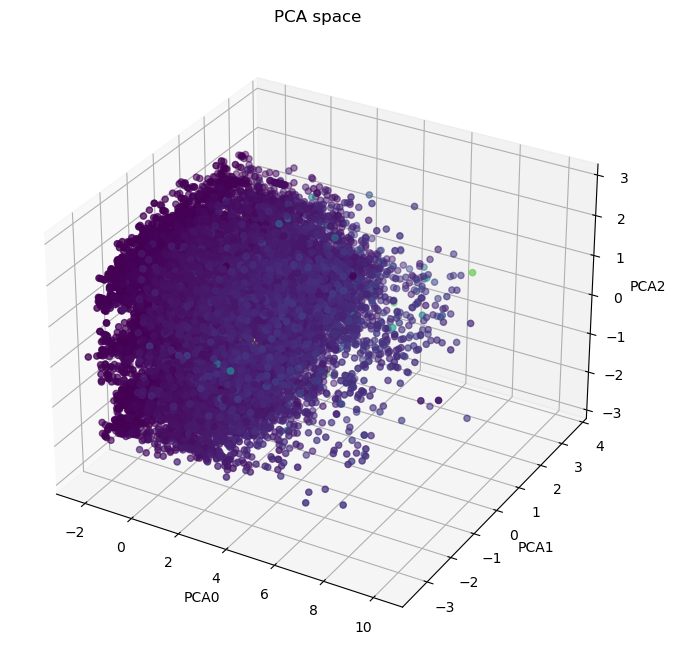

In [18]:
XPCA = feature_PCA(df, X_cols_1, y_col_1, plot=True)

In [22]:
for i, outcome in enumerate([y_col_1, y_col_2, y_col_3]):
    for j, explanatory in enumerate([X_cols_1, X_cols_2, X_cols_3]):
        print(f"Model {i*3+j+1}")
        print(f"Outcome variable: {outcome}")
        print(f"Explanatory variable set: X_{j+1}")
        benchmark_models(df, X_cols=explanatory, y_col=outcome)
        print("\n")

Model 1
Outcome variable: trade_price
Explanatory variable set: X_1
Number of observations: 34344/43383
OLS MSE: 353.017005002352
Lasso MSE: 374.1097891057342
Ridge MSE: 353.0173740891603
Random Forest MSE: 154.96828490789568
Gradient Boosting MSE: 143.20387560903973


Model 2
Outcome variable: trade_price
Explanatory variable set: X_2
Number of observations: 43383/43383
OLS MSE: 319.0132516862824
Lasso MSE: 327.36327523108525
Ridge MSE: 319.0129306209468
Random Forest MSE: 200.96036864079136
Gradient Boosting MSE: 200.50187412353847


Model 3
Outcome variable: trade_price
Explanatory variable set: X_3
Number of observations: 34344/43383
OLS MSE: 762.7433172415257
Lasso MSE: 772.6439722126386
Ridge MSE: 762.7441271491298
Random Forest MSE: 254.85252480178346
Gradient Boosting MSE: 262.1928849618694


Model 4
Outcome variable: trade_price_log
Explanatory variable set: X_1
Number of observations: 34344/43383
OLS MSE: 0.9652796255375111
Lasso MSE: 2.0694651928036882
Ridge MSE: 0.965276016

From the benchmarking results, we can see that inclusion of last_trade variables yields positive performance gains while maintaining 80% of all training data.  
Hence in the next section, we will use the full set of features to train the deep neural network.